# Plot frequency of occurrence of tweets about the best animals 

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import nltk
import seaborn as sns

### Read in the CSV made separately
twitter_scrape_retweets.ipynb creates this; I saved a version as "tweet_replies_lock" so that I wouldn't lose the results

In [2]:
tweet_num = 1273621086933057536
input_filename = 'tweet_replies_'+str(tweet_num)+'.csv'
input_filepath = os.path.join('Data', input_filename)

df_retwe = pd.read_csv(input_filepath)
df_retwe.head()

,id,created_at,favorites,retweets,text
0,1273740685745758208,2020-06-18 22:13:39,0,0,b'@rachelgwenllian sea horse'
1,1273740666619736064,2020-06-18 22:13:34,0,0,b'@rachelgwenllian https://t.co/ey4R7Zaayd'
2,1273740663633444865,2020-06-18 22:13:33,0,0,b'@rachelgwenllian Mine is the seahorse'
3,1273740663490740224,2020-06-18 22:13:33,0,0,b'@rachelgwenllian Whale'
4,1273740657283207170,2020-06-18 22:13:32,0,0,b'@rachelgwenllian https://t.co/fvBFhElf2N'


### Concatenate all of the tweeted words and search for keywords
I couldn't quite decide how to do this so first I created a list with all of the words from all of the tweets, thinking I might search that list. But in the following block, I used the original pandas DataFrame to run the analysis. 


In [3]:
all_the_words_nest = []

for index, row in df_retwe.iterrows():
    row_words = row.text.split(" ")
    all_the_words_nest.append(row_words)
    
all_the_words = [item for sublist in all_the_words_nest for item in sublist]

In [4]:
keywords = ['plankton', 'cuttlefish', 'ray', 'shark', 'dragon', 'orca', 'horse', 
            'jelly', 'dolphin', 'whale', 'puffin', 'penguin', 'sunfish', 'narwhal', 'manatee',
            'squid', 'mola', 'octopus', 'otter', 'turtle', 'nudibranch', 'mantis',
            'starfish', 'hermit', 'clown', 'lion', 'killer', 'sting', 'tang', 'surgeon',
            'dory', 'nemo'
           ]

a = df_retwe['text'].str.lower().str.cat(sep=' ')
# nltk.download('punkt')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

N = 1000
common_words = pd.DataFrame(word_dist.most_common(N),
                    columns=['Word', 'Frequency'])

output_filename = 'common_words_'+str(tweet_num)+'.csv'
output_filepath = os.path.join('Data', input_filename)

common_words.to_csv(output_filepath)

### Use the keywords to create a new DataFrame with the counts of each keyword
This was a little more brute force than I would've liked&mdash;not as elegant as it could be. But examination of the CSV allows you to pick the keywords that rank at the top (and are actually critters) and analyze them further. 

In [5]:
counts = np.zeros(len(keywords))
data = {'keywords':keywords, 'mentions':counts}
keyword_counts = pd.DataFrame(data)

for word in keywords:
    df_retwe[word] = df_retwe.astype(str).sum(axis=1).str.contains(word)

df_keywords = df_retwe[keywords]

key_sums = df_keywords.sum()
key_sums

plankton        1
cuttlefish      1
ray            64
shark          38
dragon          1
orca           24
horse         310
jelly          19
dolphin        63
whale          84
puffin          0
penguin         1
sunfish         0
narwhal         5
manatee         7
squid           4
mola            0
octopus        52
otter           9
turtle          6
nudibranch      1
mantis          0
starfish        3
hermit          5
clown           6
lion           29
killer         10
sting           6
tang            1
surgeon         0
dory            0
nemo            1
dtype: int64

### Combine terms that likely mean the same thing
- e.g., "killer" and "orca" both refer to the same thing
- can't currently distinguish response of plain "whale" from something like "killer whale"

In [6]:
key_sums['orca'] = key_sums['orca']+key_sums['killer']
key_sums['seahorse'] = key_sums['horse']
key_sums['jellyfish'] = key_sums['jelly']
key_sums['hermit crab'] = key_sums['hermit']
key_sums['clownfish'] = key_sums['clown']+key_sums['nemo']
key_sums['royal blue tang'] = key_sums['tang']+key_sums['dory']+key_sums['surgeon']
del key_sums['killer'], key_sums['horse'], key_sums['jelly'], key_sums['tang']
del key_sums['dory'], key_sums['surgeon'], key_sums['hermit']
del key_sums['clown'], key_sums['nemo']
    
key_sums

plankton             1
cuttlefish           1
ray                 64
shark               38
dragon               1
orca                34
dolphin             63
whale               84
puffin               0
penguin              1
sunfish              0
narwhal              5
manatee              7
squid                4
mola                 0
octopus             52
otter                9
turtle               6
nudibranch           1
mantis               0
starfish             3
lion                29
sting                6
seahorse           310
jellyfish           19
hermit crab          5
clownfish            7
royal blue tang      1
dtype: int64

In [7]:
df_key_sums = pd.DataFrame(key_sums)
df_key_sums.reset_index(inplace = True)
df_key_sums.columns = ['keywords', 'mentions']
df_key_sums.sort_values(by = 'mentions', ascending = False, inplace = True)
df_key_sums

,keywords,mentions
23,seahorse,310
7,whale,84
2,ray,64
6,dolphin,63
15,octopus,52
3,shark,38
5,orca,34
21,lion,29
24,jellyfish,19
16,otter,9


### Plot the results!

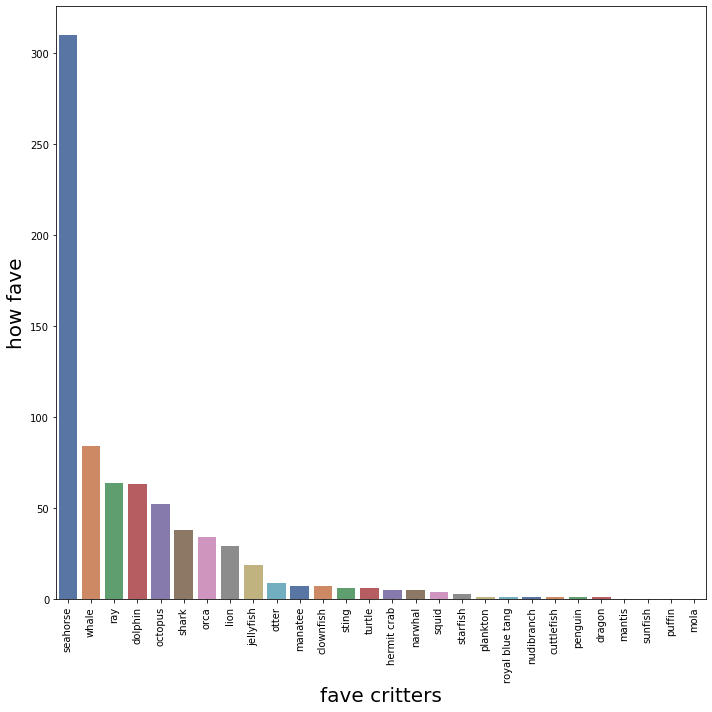

In [8]:
bar_width = 0.35

fig, axs = plt.subplots(figsize = (10, 10))
barplot = sns.barplot(x=df_key_sums['keywords'], y=df_key_sums['mentions'], palette="deep")
plt.xticks(rotation=90)
axs.set_xlabel('fave critters', fontsize=20)
axs.set_ylabel('how fave', fontsize=20)
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=20
plt.tight_layout()
# plt.bar(df_key_sums['keywords'], df_key_sums['sums'])

In [9]:
fig = barplot.get_figure()

output_filename = 'tweet_replies_'+str(tweet_num)+'.png'
output_filepath = os.path.join('Figs', input_filename)

fig.savefig(output_filepath) 

ValueError: Format 'csv' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)